In [1]:
from typing import List
try:
    import spacy
except:
    %pip install spacy
    import spacy

try:
    from sentence_transformers import CrossEncoder
except:
    %pip install sentence-transformers
    from sentence_transformers import CrossEncoder
    
try:
    from transformers import pipeline
except:
    %pip install transformers
    from transformers import pipeline

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import MarianMTModel, MarianTokenizer
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

try:
    import torch
except:
    %pip install torch
    import torch
    
try: 
    import PyPDF2
except:
    %pip install pypdf
    import PyPDF2

try:
    from llama_index import SimpleDirectoryReader
except:     
    %pip install llama-index
    from llama_index import SimpleDirectoryReader
    
#     !pip install GPT4All
#     !pip install einops

device = ['cuda' if torch.cuda.is_available() else 'cpu', "cpu"]
device = device[0]

/home/joramas/miniconda/envs/thesis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
collection_name = "pdfs"

In [3]:

import pandas as pd

# this is a loader for multi-xscience dataset
def get_text():
    
    df = pd.read_json('documents/Multi-XScience/train.json')
    
    for idx,row in df.iterrows():
        yield row

def get_custom_documents():
    ...


In [4]:
def translate_es_en(spanish_text):
    device = 'cuda'
    # Load the pre-trained model and tokenizer
    model_name = "Helsinki-NLP/opus-mt-es-en"  # Spanish to English translation model
    model = MarianMTModel.from_pretrained(model_name)
    tokenizer = MarianTokenizer.from_pretrained(model_name)


    # Tokenize the Spanish text
    spanish_text_split = [spanish_text[i:i + 300] for i in range(0, len(spanish_text), 300)]
    
    translated_text = []
    for text in spanish_text_split:
        inputs = tokenizer.encode(text, return_tensors="pt")
        translated_ids = model.generate(inputs, max_length=100, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
        translated_text.append(tokenizer.decode(translated_ids[0], skip_special_tokens=True))
    
    return " ".join(translated_text)


In [5]:
nlp_es = spacy.load('es_core_news_lg')
nlp = spacy.load('en_core_web_sm')

# def filter_tokens(doc):
#   doc = nlp(doc)
#   filtered_tokens = [token.text for token in doc if not token.is_oov]
#   return " ".join(filtered_tokens)
  
def remove_stop_words(text: str) -> str:
  doc = nlp(text)
  text_parts = [token.text for token in doc if not token.is_stop]
  return " ".join(text_parts)
  
def split_paragraphs(text: str) -> List[str]:
  paragraphs = []
  doc = nlp(text)
  current_paragraph = []
  for token in doc:
    # Check if the token is a newline character (end of paragraph)
    if "\n" in token.text:
        # Append the current paragraph to the list of paragraphs
        # if len(token.text) > 1:
        paragraphs.append(" ".join(current_paragraph))
        current_paragraph = []
        # Reset the current paragraph
    else:
        # Append the token's text to the current paragraph
        current_paragraph.append(token.text)
        
  paragraphs.append(current_paragraph)
  return paragraphs


def split_sentences(text: list[str]) -> List[str]:
  text = " ".join(text)
  doc = nlp(text)
  sentences = [sent.text for sent in doc.sents]
  return sentences

def group_sentences_semantically(sentences: List[str], threshold: int) -> List[str]:
  docs = [nlp(sentence) for sentence in sentences]
  
  segments = []

  start_idx = 0
  end_idx = 1
  segment = [sentences[start_idx]]
  model = CrossEncoder('cross-encoder/stsb-roberta-large')
  
  while end_idx < len(docs):
    similarity = model.predict([[str(docs[start_idx]), str(docs[end_idx])]])
    if similarity >= threshold:
      segment.append(str(docs[end_idx]))
    else:
      segments.append(" ".join(segment))
      start_idx = end_idx
      segment = [sentences[start_idx]]
    end_idx += 1

  if segment:
    segments.append(" ".join(segment))
  
  del model
  
  return segments

def split_text(text: str) -> List[str]:
  text_no_stop_words = remove_stop_words(text)
  # sentences = split_paragraphs(text_no_stop_words)
  paragraphs = split_paragraphs(text_no_stop_words)
  sentences = []
  
  for p in paragraphs:
    print("paragraph", p)
    if len(p) > 100:
      sentences.extend(group_sentences_semantically(split_sentences(p), 0.15))
    else:
      sentences.append(p)
  # return group_sentences_semantically(sentences, 0.15)
  return sentences

In [8]:
from tools.embeddings import  Embedding
documents = []
embedModel = Embedding()
for row in get_text():
    sentences = []
    # print(row)
    d = row["ref_abstract"]
    for key in row['ref_abstract']:
        sentences.extend(split_text(key+d[key]['abstract']))
    sentences.extend(split_text(row['abstract']))
    
    vectors = embedModel.embed(sentences)
    documents.append((vectors,row['related_work']))
del embedModel


aid                                                   math9912167
mid                                                    1631980677
abstract        Author(s): Kuperberg, Greg; Thurston, Dylan P....
related_work    Two other generalizations that can be consider...
ref_abstract    {'@cite_16': {'mid': '1481005306', 'abstract':...
Name: 0, dtype: object
aid                                                   math9912167
mid                                                    1631980677
abstract        Author(s): Kuperberg, Greg; Thurston, Dylan P....
related_work    Two other generalizations that can be consider...
ref_abstract    {'@cite_16': {'mid': '1481005306', 'abstract':...
Name: 0, dtype: object
paragraph ['@cite_16This', 'note', 'sequel', 'earlier', 'paper', 'title', '[', '4', ']', 'describes', 'invariants', 'rational', 'homology', '3', '-', 'spheres', 'associated', 'acyclic', 'orthogonal', 'local', 'systems', '.', 'work', 'spirit', 'Axelrod', '–', 'Singer', 'papers', '[', '1', ']', 

In [ ]:
from qdrant_client import QdrantClient
from qdrant_client.models import PointStruct
from qdrant_client.models import Distance, VectorParams
# from qdrant_client.configuration import Configuration
# from qdrant_client.api.default_api import DefaultApi

client =  QdrantClient(host="localhost", port=6333)

client.recreate_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=384, distance=Distance.COSINE)
)

client.upsert(
    collection_name=collection_name, 
    points=[
        PointStruct(
        id=i,
        vector=v.tolist(),
        payload={}
        )
        for i,v in enumerate(vectors)
    ]
)


UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

In [ ]:
%pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

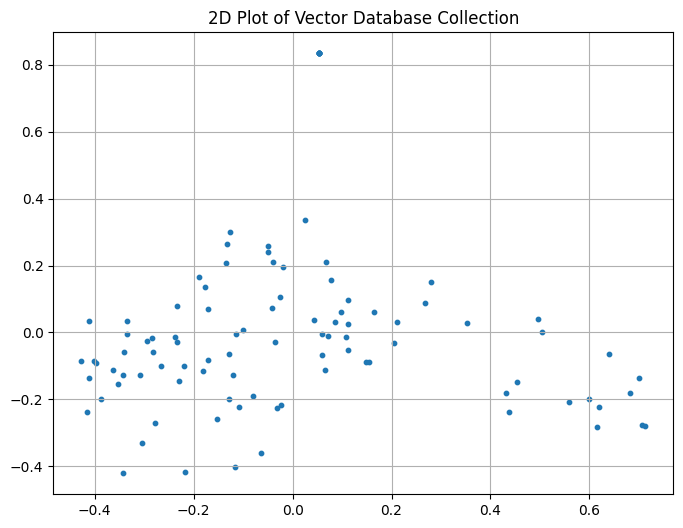

In [ ]:
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors)

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], s=10)
plt.title('2D Plot of Vector Database Collection')
plt.grid(True)

In [ ]:
plt.show()

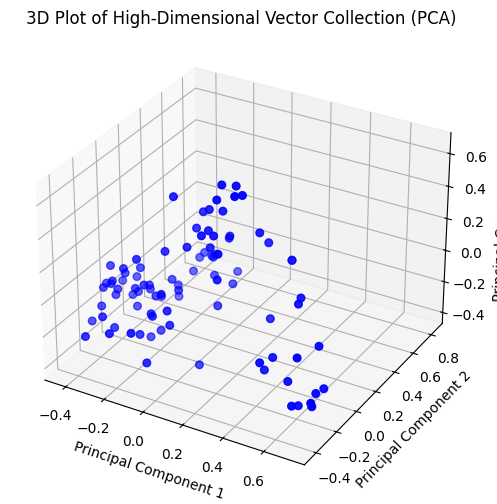

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import numpy as np

# Assuming vector_collection is a list of high-dimensional vectors
# Example:
# vector_collection = [[x1, x2, x3, ..., xn], [y1, y2, y3, ..., yn], ...]

# Convert the vector collection to a numpy array
vector_collection = np.array(vectors)

# Perform PCA to reduce the vectors to 3D
pca = PCA(n_components=3)
vectors_3d = pca.fit_transform(vector_collection)

# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Extract the x, y, and z components from the reduced vectors
x = vectors_3d[:, 0]
y = vectors_3d[:, 1]
z = vectors_3d[:, 2]

# Create the scatter plot
ax.scatter(x, y, z, c='b', marker='o', s=30)

# Set labels for the axes
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Set a title for the plot
ax.set_title('3D Plot of High-Dimensional Vector Collection (PCA)')

# Show the plot
plt.show()


In [ ]:
%%capture
!pip install huggingface_hub
!pip install transformers
!pip install accelerate
!pip install bitsandbytes>=0.39.0 -q


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, TextStreamer

In [ ]:
model_id = 'Deci/DeciLM-6b-instruct'

# model = AutoModelForCausalLM.from_pretrained(model_id,
#                                              device_map="auto",
#                                              trust_remote_code=True
#                                              )